In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("../data/podcast.csv")

In [3]:
df.shape

(17563, 535)

In [4]:
# keep a dictionary of index to name for later lookup
podcast_lookup = df.to_dict()['name']

In [5]:
# TF-IDF for feature selection
tfidf_vectorizer = TfidfVectorizer(min_df=5)
X = tfidf_vectorizer.fit_transform(df['combined'].values.astype('U'))

In [6]:
X.shape

(17563, 41015)

In [7]:
weight_vector = np.sort(tfidf_vectorizer.idf_)

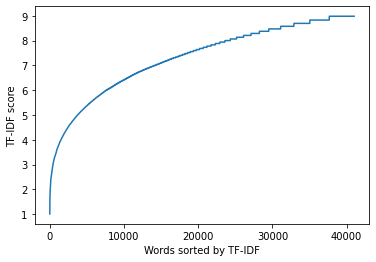

In [8]:
# plot Tf-IDF score against word count to identify a suitable cut-off TF-IDF score
# to truncate our features
plt.plot(weight_vector)
plt.ylabel("TF-IDF score")
plt.xlabel("Words sorted by TF-IDF")
plt.show()

In [9]:
# example of words
indices = np.argsort(tfidf_vectorizer.idf_)[::-1]
features = tfidf_vectorizer.get_feature_names()

n = 20
top_features = [features[i] for i in indices[:n]]
low_features = [features[i] for i in indices[-n:]]
print("Highest TF-IDF features:")
for ind,i in enumerate(top_features):
    print(f"{ind+1} = {i}")

Highest TF-IDF features:
1 = tiefling
2 = humblebrags
3 = circadian
4 = humorist
5 = postprocessing
6 = revives
7 = humoring
8 = stallions
9 = postponement
10 = forgetfulness
11 = nita
12 = scoobie
13 = circumference
14 = syncs
15 = clamping
16 = circumvent
17 = drexler
18 = forgone
19 = stampede
20 = hugest


In [10]:
# keep only words which have a Tf-IDF score greater than 5
ind = np.argwhere(tfidf_vectorizer.idf_>5.).flatten()

In [11]:
ind.shape

(37267,)

In [12]:
X = X.toarray()[:,ind]

In [13]:
X.shape

(17563, 37267)

In [17]:
# Give less weight to duration
df.loc[:, df.columns.str.startswith('duration_')] = df.loc[:, df.columns.str.startswith('duration_')]*0.01

In [18]:
# Give less weight to episode count
df.loc[:, df.columns.str.startswith('episodecount_')] = df.loc[:, df.columns.str.startswith('episodecount_')]*0.02

In [19]:
# Combine the TF-IDF word vectors with the other features
other_features = df.iloc[:,7:-1].to_numpy()
other_features.shape

(17563, 527)

In [20]:
features = np.hstack((other_features,X))

In [21]:
features.shape

(17563, 37794)

In [22]:
# Calculate the pair-wise cosine similarity of pocasts based on the given features
similarities = cosine_similarity(features)

In [23]:
# Square matrix of cosine similarity
# Where the diagonal = 1.0
similarities.shape

(17563, 17563)

In [24]:
#podcast_lookup

In [25]:
podcast_lookup[5417]

'Dave & Chuck the Freak Podcast'

In [26]:
# test the produced recommendations
p = 0
ind = np.argsort(similarities[p,:])

print(f"Top 10 recommendations for '{df.iloc[p]['name']}' by {df.iloc[p]['artist']} (genre: {df.iloc[p]['primary_genre']})")
print("-------------------------------")

df.iloc[ind[-5:-1], 1:7]#.reset_index(drop=True)

Top 10 recommendations for 'The Joe Rogan Experience' by Joe Rogan (genre: Comedy)
-------------------------------


,name,primary_genre,artist,episode_count,avg_duration,num_reviews
5455,Angela Yee's Lip Service,Comedy,"Angela Yee, Inc.",286,3961.716783,50
461,Morbid: A True Crime Podcast,Comedy,Morbid: A True Crime Podcast,524,3745.484733,485
5612,The Brilliant Idiots,Comedy,Charlamange Tha God and Andrew Schulz,87,6458.034483,50
5417,Dave & Chuck the Freak Podcast,Comedy,Dave & Chuck the Freak Podcast,400,12412.512500,50


In [27]:
# sort and reduce the matrix so each row is ordered by cosine similarity 
top10 = similarities.argsort()[:,::-1][:,1:11]

In [28]:
top10.shape

(17563, 10)

In [29]:
top10_score = np.sort(similarities)[:,::-1][:,1:11]

In [30]:
nodes = [{"group":int(i), "name":j} for i,j in podcast_lookup.items()]

In [31]:
# Create a JSON to hold the recommendations
links = []

for ind,recommend in enumerate(zip(top10,top10_score)):
    
    for i,j in zip(recommend[0], recommend[1]):
        
        links.append({"source":int(ind), "target":int(i), "value":float(j)})

In [32]:
recommendations = {"links":links, "nodes":nodes}

In [33]:
recommendations

{'links': [{'source': 0, 'target': 5417, 'value': 0.9135867619827567},
  {'source': 0, 'target': 5612, 'value': 0.9113833725795184},
  {'source': 0, 'target': 461, 'value': 0.91053850041037},
  {'source': 0, 'target': 5455, 'value': 0.9054948250145999},
  {'source': 0, 'target': 5680, 'value': 0.8855183149592019},
  {'source': 0, 'target': 4623, 'value': 0.8815988564062008},
  {'source': 0, 'target': 5712, 'value': 0.867737799119047},
  {'source': 0, 'target': 5059, 'value': 0.8646514925466724},
  {'source': 0, 'target': 4310, 'value': 0.8597477211093795},
  {'source': 0, 'target': 4376, 'value': 0.8460286850889304},
  {'source': 1, 'target': 1300, 'value': 0.9764320548420187},
  {'source': 1, 'target': 1125, 'value': 0.9737714937647673},
  {'source': 1, 'target': 2217, 'value': 0.9730126738033877},
  {'source': 1, 'target': 1126, 'value': 0.9705168300306655},
  {'source': 1, 'target': 2792, 'value': 0.9704225888587803},
  {'source': 1, 'target': 2238, 'value': 0.9702646853696161},
  {

In [34]:
import json
with open('recommendations_top10.json', 'w') as f:
    json.dump(recommendations, f)